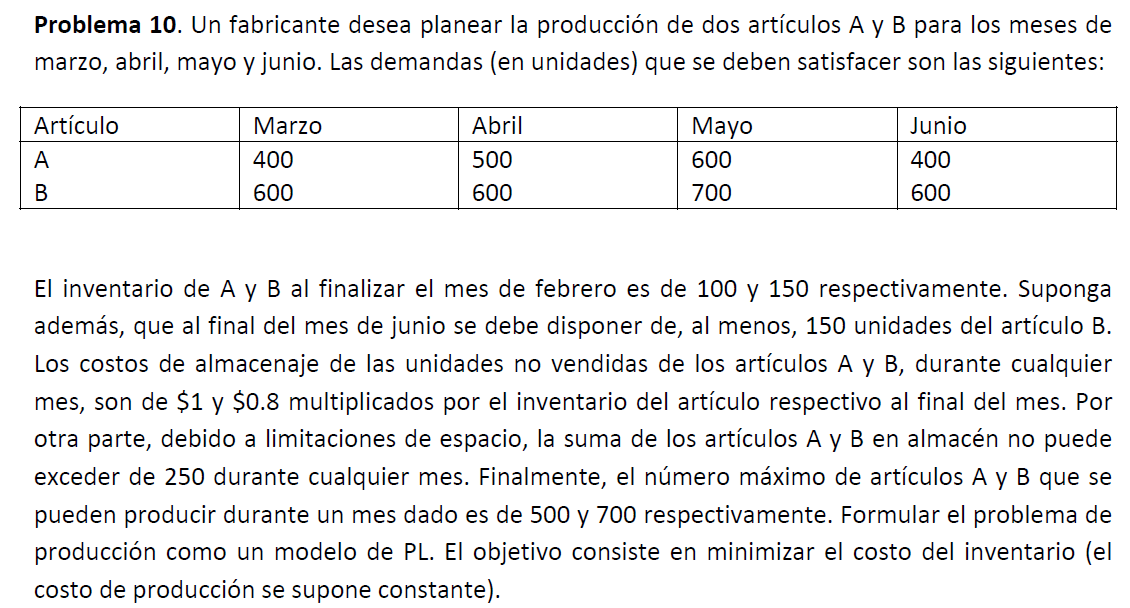

## Sets
I es el conjunto de artículos (i = 1 es A, i = 2 es B)\
T es el conjunto de meses (t = 1 es marzo, t = 2 es april, t = 3 es mayo, t = 4 es junio)

In [18]:
import pyomo.environ as pe
import pyomo.opt as po

In [19]:
model = pe.ConcreteModel()

In [20]:
model.I = pe.RangeSet(1,2)
model.T = pe.RangeSet(1,4)

## Parameters

Demit es la cantidad de unidades demandadas del artículo i en el mes t (unidad)\
Iniciali es el inventario inicial del artículo i al principio de marzo (unidad)\
Capi es la cantidad máxima del artículo i que se puede producir durante cualquier mes (unidad)\
Chi es el costo de inventario de cada mes del artículo i (dolar/unidad)\
Junio es la cantidad de unidades del artículo B en inventario al final de mes de junio (unidad)\
Alm es el almacenamiento permitido de la suma de los dos artículos en cualquier mes (unidad)

In [21]:
Dem = {(1,1): 400,   (1,2): 500,   (1,3): 600,   (1,4): 400,  
       (2,1): 600,   (2,2): 600,   (2,3): 700,   (2,4): 600}
Inicial = {1: 100, 2: 150}
Cap = {1: 500, 2: 700}
Ch = {1: 1, 2: 0.8}
Junio = 150
Alm = 250

In [22]:
model.Dem = pe.Param(model.I, model.T, initialize = Dem) #Demanda
model.Inicial = pe.Param(model.I, initialize = Inicial) #Inventario inicial
model.Cap = pe.Param(model.I, initialize = Cap) #Capacidad máxima
model.Ch = pe.Param(model.I, initialize = Ch) #Costo de inventario
model.Junio = pe.Param(initialize = Junio) #Inventario final junio
model.Alm  =pe.Param(initialize = Alm) #Almacenamiento

## Variables
Qpit es la cantidad de unidades a producir del artículo i en el mes t\
Qhit es la cantidad de unidades en inventario del artículo i en el mes t

In [23]:
model.Qp = pe.Var(model.I, model.T, domain = pe.NonNegativeReals)
model.Qh = pe.Var(model.I, model.T, domain = pe.NonNegativeReals)

## Objective

In [24]:
Z = sum(model.Ch[i] * model.Qh[i,t] for t in model.T for i in model.I)
model.objective = pe.Objective(sense = pe.minimize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : Qh[1,1] + 0.8*Qh[2,1] + Qh[1,2] + 0.8*Qh[2,2] + Qh[1,3] + 0.8*Qh[2,3] + Qh[1,4] + 0.8*Qh[2,4]


## Constraints

In [25]:
#Ecuación de inventario
model.eqInv = pe.ConstraintList()
for i in model.I:
    for t in model.T:
        if t == 1:           
            Inv_lhs = model.Qh[i,t]
            Inv_rhs = model.Inicial[i] + model.Qp[i,t] - model.Dem[i,t]
        else:
            Inv_lhs = model.Qh[i,t]
            Inv_rhs = model.Qh[i,t-1] + model.Qp[i,t] - model.Dem[i,t]    
        model.eqInv.add(Inv_lhs == Inv_rhs)   
model.eqInv.pprint()

eqInv : Size=8, Index=eqInv_index, Active=True
    Key : Lower : Body                                : Upper : Active
      1 :   0.0 :     Qh[1,1] - (100 + Qp[1,1] - 400) :   0.0 :   True
      2 :   0.0 : Qh[1,2] - (Qh[1,1] + Qp[1,2] - 500) :   0.0 :   True
      3 :   0.0 : Qh[1,3] - (Qh[1,2] + Qp[1,3] - 600) :   0.0 :   True
      4 :   0.0 : Qh[1,4] - (Qh[1,3] + Qp[1,4] - 400) :   0.0 :   True
      5 :   0.0 :     Qh[2,1] - (150 + Qp[2,1] - 600) :   0.0 :   True
      6 :   0.0 : Qh[2,2] - (Qh[2,1] + Qp[2,2] - 600) :   0.0 :   True
      7 :   0.0 : Qh[2,3] - (Qh[2,2] + Qp[2,3] - 700) :   0.0 :   True
      8 :   0.0 : Qh[2,4] - (Qh[2,3] + Qp[2,4] - 600) :   0.0 :   True


In [26]:
#Capacidad
model.capacity = pe.ConstraintList()
for i in model.I:
    for t in model.T:
        cap_lhs = model.Qp[i,t]
        cap_rhs = model.Cap[i]
        model.capacity.add(cap_lhs == cap_rhs)
model.capacity.pprint()

capacity : Size=8, Index=capacity_index, Active=True
    Key : Lower : Body    : Upper : Active
      1 : 500.0 : Qp[1,1] : 500.0 :   True
      2 : 500.0 : Qp[1,2] : 500.0 :   True
      3 : 500.0 : Qp[1,3] : 500.0 :   True
      4 : 500.0 : Qp[1,4] : 500.0 :   True
      5 : 700.0 : Qp[2,1] : 700.0 :   True
      6 : 700.0 : Qp[2,2] : 700.0 :   True
      7 : 700.0 : Qp[2,3] : 700.0 :   True
      8 : 700.0 : Qp[2,4] : 700.0 :   True


In [27]:
#Junio
June_lhs = model.Qh[2,4]
June_rhs = model.Junio
model.JuneCons = pe.Constraint(expr = (June_lhs >= June_rhs))
model.JuneCons.pprint()

JuneCons : Size=1, Index=None, Active=True
    Key  : Lower : Body    : Upper : Active
    None : 150.0 : Qh[2,4] :  +Inf :   True


## Solver

In [28]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpl6ih4_g8.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpd7b2ggdw.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpujz7b_tm.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpujz7b_tm.pyomo.lp'...
18 rows, 17 columns, 32 non-zeros
118 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpd7b2ggdw.glpk.glp'...
96 lines were written
GLPK Simplex Optimizer 5.0
18 rows, 17 columns, 32 non-zeros
Preprocessing...
~     0: obj =   1.820000000e+03  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (32356 bytes)
Writing basic solution to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpl6ih4_g8.glpk.raw'...
44 lines were written


In [29]:
for t in model.T:
    for i in model.I:
        print(pe.value(model.Qh[i,t]))        

200.0
250.0
200.0
350.0
100.0
350.0
200.0
450.0


In [30]:
for t in model.T:
    for i in model.I:
        print(pe.value(model.Qp[i,t])) 

500.0
700.0
500.0
700.0
500.0
700.0
500.0
700.0


In [31]:
print(pe.value(model.objective)) 

1820.0
